In [24]:
import torch 
from torch import nn
import json

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights 

import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

2.5.1+cu121


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from pathlib import Path

data_root = Path("food-101")
print(data_root.exists())
print((data_root / "images").exists())
print((data_root / "meta").exists())

True
True
True


In [5]:
from food101_dataset import idx_food101, Food101Dataset, load_json
samples, class_to_idx = idx_food101("food-101")

data = Food101Dataset(samples, class_to_idx)
print(len(data))

img, label = data[10001]
print(type(img), label)

101000
<class 'PIL.Image.Image'> 10


In [6]:
samples, class_to_idx = idx_food101("food-101")
print(len(class_to_idx))
print(list(class_to_idx.keys())[:10])

101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [7]:
# from sklearn.model_selection import train_test_split

# samples, class_to_idx = idx_food101("food-101")
# labels = [label for _, label in samples]

# train_set, temp_set = train_test_split(
#     samples,
#     test_size=0.2,
#     stratify=labels,
#     random_state=78
# )

# temp_set_labels = [label for _, label in temp_set]

# val_set, test_set = train_test_split(
#     temp_set,
#     test_size = 0.5,
#     stratify=temp_set_labels,
#     random_state=78
# )

In [8]:
# output_dir = Path("data")
# output_dir.mkdir(parents=True, exist_ok=True)

# json.dump(train_set, open("data/train.json", "w"))  
# json.dump(val_set, open("data/val.json", "w"))
# json.dump(test_set, open("data/test.json", "w"))
# json.dump(class_to_idx, open("data/class_to_idx.json", "w"))

In [9]:
train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
     
])

In [10]:
train_samples = load_json("data/train.json")
val_samples = load_json("data/val.json")
test_samples = load_json("data/test.json")
class_to_idx = load_json("data/class_to_idx.json")

train_ds = Food101Dataset(train_samples, class_to_idx, transform=train_tf)
test_ds = Food101Dataset(test_samples, class_to_idx, transform=val_tf)
val_ds = Food101Dataset(val_samples, class_to_idx, transform=val_tf)

In [11]:
print(f"Train set: {len(train_ds)} samples")
print(f"Validation set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")
print(f"Class mapping saved for {len(class_to_idx)} classes")

Train set: 80800 samples
Validation set: 10100 samples
Test set: 10100 samples
Class mapping saved for 101 classes


In [19]:
# CALCULATING THE MEAN AND STD OF THE DATASET ITSELF


# tmp_tf = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor()
# ])

# train_tmp = Food101Dataset(train_samples, class_to_idx, transform=tmp_tf)

# tr_dl = DataLoader(train_tmp, batch_size = 64, shuffle = False, num_workers=4)

# mean = torch.zeros(3)
# std = torch.zeros(3)
# n_pixels = 0

# for imgs, _ in tr_dl:
#     b,c,h,w = imgs.shape
#     pixels = b*h*w

#     mean += imgs.sum(dim = [0,2,3])
#     std += (imgs**2).sum(dim = [0,2,3])
#     n_pixels += pixels

# mean = mean / n_pixels
# std = (std / n_pixels - mean**2).sqrt()

# print(f"Mean: {mean}")
# print(f"Standard deviation: {std}")

In [12]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers = 4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers = 4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers = 4, pin_memory=True)

In [13]:
images, labels = next(iter(train_loader))

print(images.shape)
print(images.dtype)
print(labels.shape)
print(labels.dtype)

torch.Size([32, 3, 224, 224])
torch.float32
torch.Size([32])
torch.int64


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

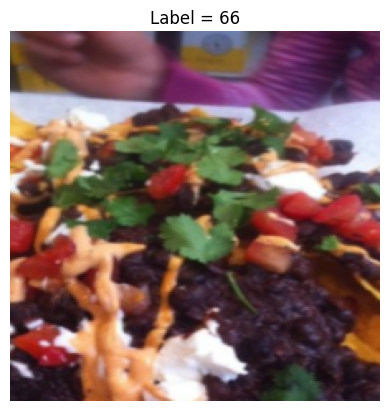

In [20]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

img = images[5]
img = img * std + mean
img = img.clamp(0,1)
img = img.permute(1,2,0)

plt.imshow(img)
plt.title(f"Label = {labels[5].item()}")
plt.axis("off")

In [25]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights = weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Ashraf/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 22.7MB/s]


In [26]:
num_classes = 101
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [27]:
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

In [28]:
model = model.to(device)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.fc.parameters(),
    lr = 1e-3,
    weight_decay=1e-4
)